Let's do all importing and other pre-stuff here

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
#from sklearn.neighbors import LocalOutlierFactor

Import function

In [12]:
# Base path (relative to notebook)
base_path = os.path.abspath(os.path.join("..", "data", "raw", "5_EOG_EMG_sleep", "Train"))

# Helper to load all files in a given subfolder
def load_stage(stage_name):
    stage_path = os.path.join(base_path, stage_name)
    files = sorted([f for f in os.listdir(stage_path) if f.endswith('.csv')])
    print(f"Loading {len(files)} files from '{stage_name}'...")
    return [pd.read_csv(os.path.join(stage_path, f)) for f in files]

# Load all stages
raw_awake = load_stage("awake")
raw_nonrem = load_stage("nonrem")
raw_rem = load_stage("rem")

# Quick sanity check
print("Awake sample:", raw_awake[0].head())
print("NonREM sample:", raw_nonrem[0].head())
print("REM sample:", raw_rem[0].head())

Loading 229 files from 'awake'...
Loading 238 files from 'nonrem'...
Loading 163 files from 'rem'...
Awake sample:     eog  emg
0  39.0  3.0
1  36.0  4.0
2  36.0  2.0
3  40.0 -5.0
4  46.0 -2.0
NonREM sample:    eog  emg
0  0.0  5.0
1  5.0  7.0
2  7.0 -2.0
3  5.0 -5.0
4  2.0  2.0
REM sample:    eog  emg
0  8.0  0.0
1  8.0 -1.0
2  8.0  3.0
3  8.0 -1.0
4  9.0  0.0


Raw has NaNs? True
Raw has Infs? False
Length of raw_emg: 12001
Rectified sample (20–35): [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


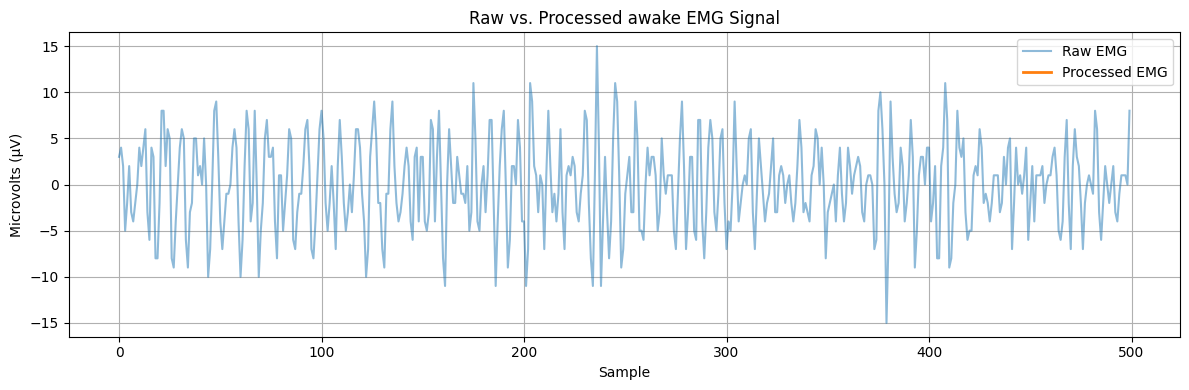

Raw has NaNs? True
Raw has Infs? False
Length of raw_emg: 12001
Rectified sample (20–35): [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


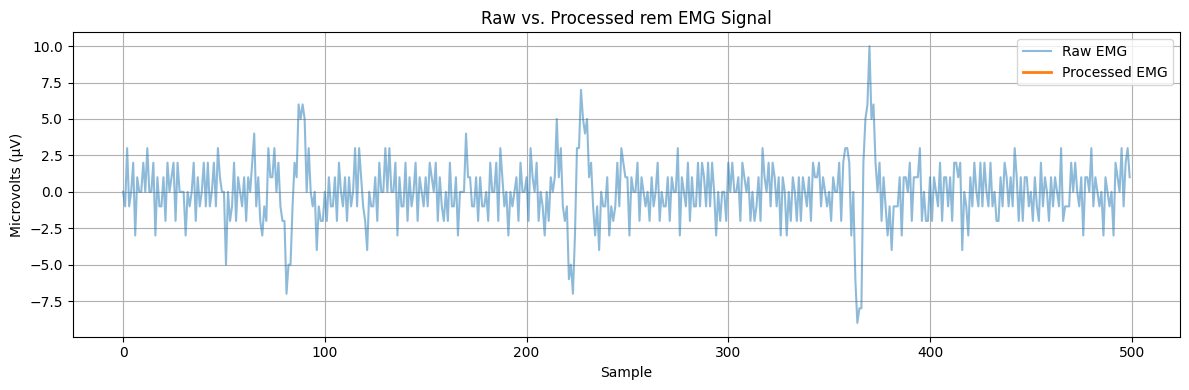

In [ ]:
# Step 1: High-pass filter definition
def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return butter(order, normal_cutoff, btype='high', analog=False)

def highpass_filter(data, cutoff=20, fs=200, order=4):
    b, a = butter_highpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Preprocess and plot EMG from a sample
def preprocess_and_plot_emg(raw_df, fs=200):
    raw_emg = np.nan_to_num(raw_df['emg'].values, nan=0.0)

    # High-pass filter
    emg_filtered = highpass_filter(raw_emg, cutoff=20, fs=fs)

    # Rectify
    emg_rectified = np.abs(emg_filtered)
    print("Raw has NaNs?", np.isnan(raw_emg).any())
    print("Raw has Infs?", np.isinf(raw_emg).any())
    print("Length of raw_emg:", len(raw_emg))
    print("Rectified sample (20–35):", emg_rectified[20:35])



    # Smooth with moving average (200 ms window)
    window = int(0.2 * fs)
    emg_smoothed = pd.Series(emg_rectified).rolling(window=window, center=True).mean()

    return emg_smoothed

# Example usage: first sample from awake
preprocessedData = preprocess_and_plot_emg(raw_awake[0])

# Plot
plt.figure(figsize=(12, 4))
plt.plot(raw_awake[0]['emg'][:500], label='Raw EMG', alpha=0.5)
plt.plot(preprocessedData[:500], label='Processed EMG', linewidth=2)
plt.title('Raw vs. Processed awake EMG Signal')
plt.xlabel('Sample')
plt.ylabel('Microvolts (μV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Example usage: first sample from rem
preprocessedData2 = preprocess_and_plot_emg(raw_rem[0])

# Plot
plt.figure(figsize=(12, 4))
plt.plot(raw_rem[0]['emg'][:500], label='Raw EMG', alpha=0.5)
plt.plot(preprocessedData2[:500], label='Processed EMG', linewidth=2)
plt.title('Raw vs. Processed rem EMG Signal')
plt.xlabel('Sample')
plt.ylabel('Microvolts (μV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()